In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Set your dataset path
DATASET_PATH = 'Dataset/images/'

# List image files
image_files = [os.path.join(DATASET_PATH, f) for f in os.listdir(DATASET_PATH) if f.endswith('.png')]

# Load an image for testing
img = cv2.imread(image_files[0])

In [2]:
def full_preprocessing_pipeline(img, target_size=(416, 416)):
    # 1. Resize
    img = cv2.resize(img, target_size)

    # 2. Normalize (convert to float32)
    img = img / 255.0
    img = img.astype(np.float32)

    # 3. Noise Reduction (Gaussian Blur)
    blurred = cv2.GaussianBlur((img * 255).astype(np.uint8), (3, 3), 0)
    # 3*3 is the kernel mask 
    # sigma= 0  controls the spread or width of the Gaussian kernel used to apply the blur.

    # Noise Reduction (Median Blur) 
    # blurred = cv2.medianBlur((img * 255).astype(np.uint8), 3)

    # 4. Contrast Adjustment (CLAHE)
    lab = cv2.cvtColor(blurred, cv2.COLOR_BGR2LAB) #take the blurred img & convert it to L,A,B Space 
    l, a, b = cv2.split(lab) #seperate each channel 
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8)) #thershold=3 , kernel size=8*8
    cl = clahe.apply(l) #apply method on lightness channel
    limg = cv2.merge((cl, a, b)) #then merge channels again
    clahe_img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB) #return the img to RGB 

    # Contrast Adjustment (Histogram Equalization - BAD RESULTS)
    # lab = cv2.cvtColor(blurred, cv2.COLOR_RGB2LAB)
    # l, a, b = cv2.split(lab)
    # l_eq = cv2.equalizeHist(l)
    # limg = cv2.merge((l_eq, a, b))
    # hist_eq_img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

    # 5. Convert to HSV
    hsv_img = cv2.cvtColor(clahe_img, cv2.COLOR_RGB2HSV) #color conversion

    # 6. Horizontal Flip 
    flipped = cv2.flip(clahe_img, 1) #Augmentation

    # datagen = ImageDataGenerator(
    #     rotation_range=20,
    #     horizontal_flip=True,
    #     brightness_range=(0.8, 1.2),
    #     zoom_range=0.2
    # )
    
    # 7. Thresholding (grayscale + binary)
    gray = cv2.cvtColor(clahe_img, cv2.COLOR_RGB2GRAY) #take the contrasted img & convert it to gray scale 
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # 8. Sharpening
    sharpening_kernel = np.array([[0, -1, 0],
                                 [-1, 5, -1],
                                 [0, -1, 0]])
    sharpened = cv2.filter2D(clahe_img, -1, sharpening_kernel) #-1 means it will use the same depth as the input image.


    # 9. Morphological Ops
    kernel = np.ones((3, 3), np.uint8) # 3*3 kernel filled by ones
    eroded = cv2.erode(thresh, kernel, iterations=1) #apply method on the thresholded img with its kernel size for jsut one time 
    dilated = cv2.dilate(thresh, kernel, iterations=1)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1) #erosion-> dilation
    closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1) #dilation-> erosion
    gradient = cv2.morphologyEx(thresh, cv2.MORPH_GRADIENT, kernel, iterations=1) #dilation - erosion

    return {
        "blured": blurred,
        "contrasted": clahe_img,
        "color_conversion": hsv_img,
        "flipped": flipped,
        "thresholded": thresh,
        "sharpened": sharpened,
        "eroded": eroded,
        "dilated": dilated,
        "opening": opening,
        "closing": closing,
        "gradient": gradient
    }

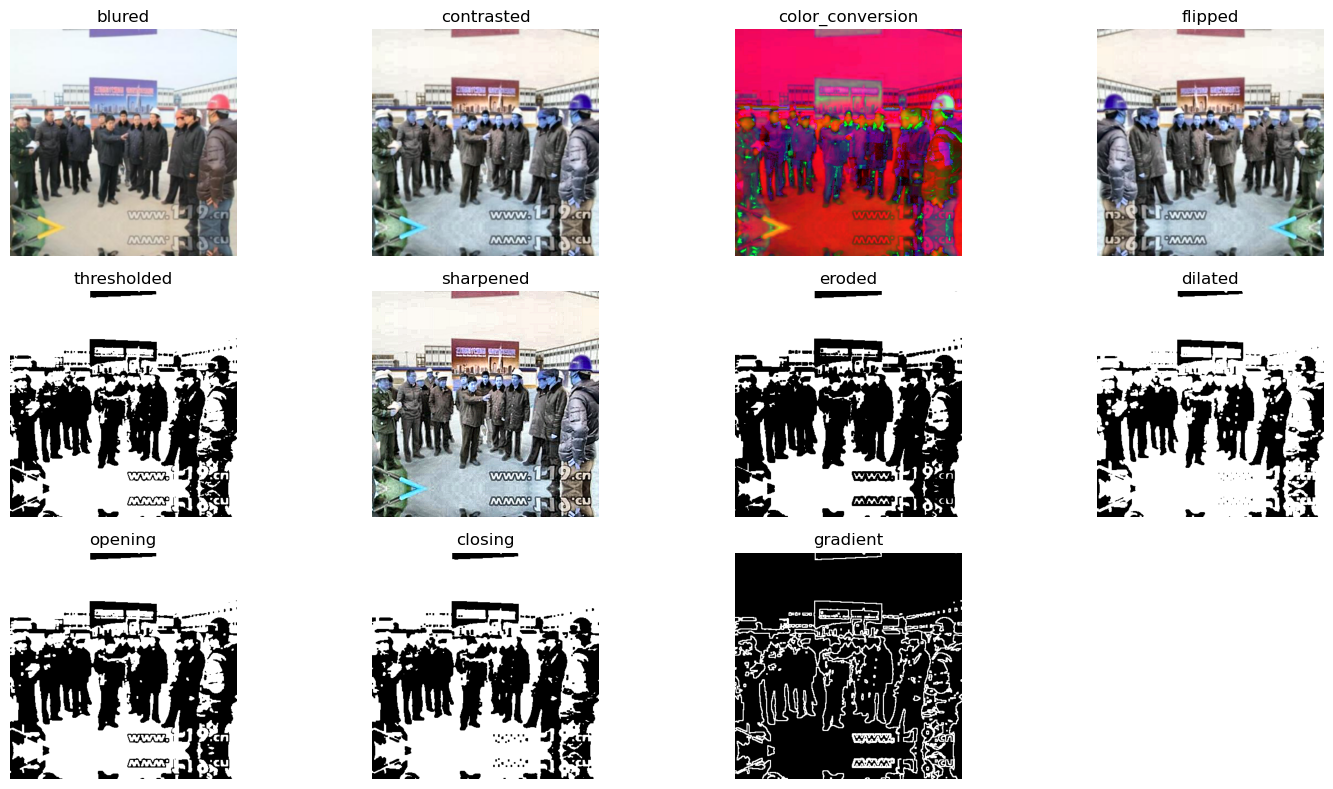

In [3]:
def show_pipeline_results(results_dict): #take dictionary-> keys: the name of operation , values: processed images
    plt.figure(figsize=(15, 8))
    for i, (name, image) in enumerate(results_dict.items()):
        plt.subplot(3, 4, i+1) #Places the i-th image at position i+1
        if len(image.shape) == 2:
            plt.imshow(image, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(name)
        plt.axis('off') #Hides x/y axes for a cleaner view
    plt.tight_layout() #Adjusts subplot spacing to avoid overlap.
    plt.show()

processed_outputs = full_preprocessing_pipeline(img)
show_pipeline_results(processed_outputs)

In [4]:
def segment_image(img):
    results = {}

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 1. Binary Thresholding
    _, binary_thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # 2. Otsu's Thresholding
    _, otsu_thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 3. Canny Edge Detection
    edges = cv2.Canny(gray, threshold1=100, threshold2=200)
   
    # 4. Find Contours (region-based)  
    contours, _ = cv2.findContours(binary_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_img = img.copy()
    cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)

    # 5. K-means Clustering
    # Reshape image to a 2D array of pixels
    pixel_vals = img.reshape((-1, 3))
    pixel_vals = np.float32(pixel_vals)

    # Define K-means criteria and parameters
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    k = 3  # Number of clusters
    _, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convert back to image format
    centers = np.uint8(centers)
    clustered_img = centers[labels.flatten()]
    clustered_img = clustered_img.reshape(img.shape)

    # Store results
    results["binary_thresh"] = binary_thresh
    results["otsu_thresh"] = otsu_thresh
    results["edges"] = edges
    results["contours"] = contour_img
    results["clustered"] = clustered_img

    return results

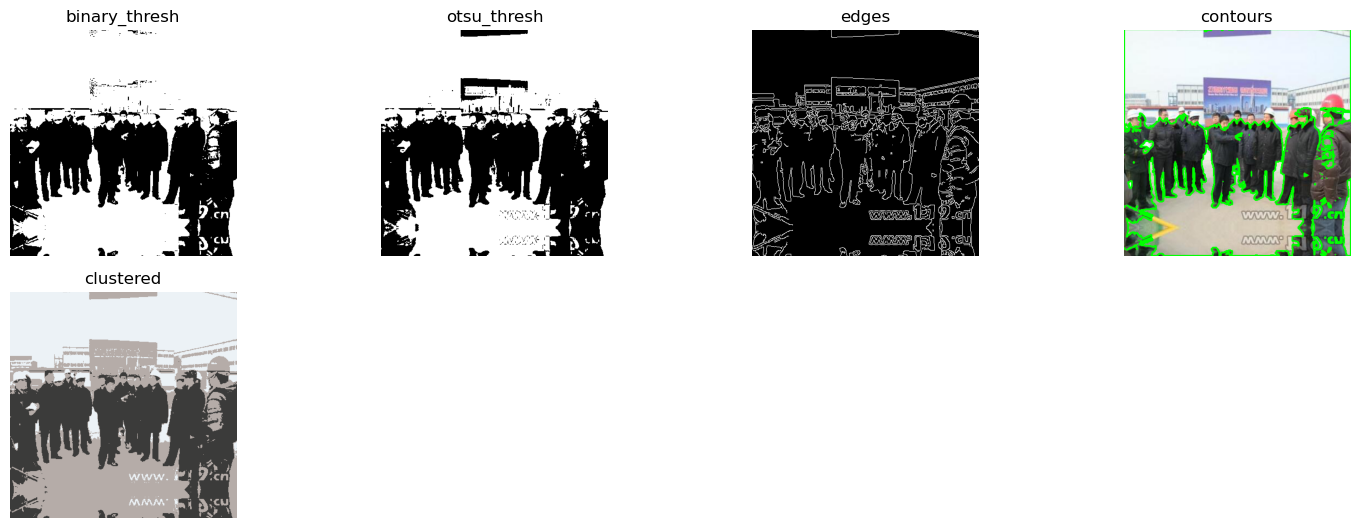

In [5]:
segmented = segment_image(img)
show_pipeline_results(segmented)

In [6]:
import xml.etree.ElementTree as ET

def parse_voc_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    objects = []
    filename = root.find("filename").text
    width = int(root.find("size/width").text)
    height = int(root.find("size/height").text)

    for obj in root.findall("object"):
        label = obj.find("name").text
        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)

        objects.append({
            "label": label,
            "bbox": (xmin, ymin, xmax, ymax)
        })

    return filename, width, height, objects

In [7]:
def draw_boxes(img, objects):
    # Predefined colors (BGR format for OpenCV)
    predefined_colors = [
        (0, 0, 255),    # Red
        (0, 255, 255),  # Yellow
        (255, 0, 0)     # Blue
    ]

    # Assign colors to labels in the order they appear
    label_color_map = {}
    color_index = 0

    for obj in objects:
        label = obj["label"]
        xmin, ymin, xmax, ymax = obj["bbox"]

        if label not in label_color_map:
            label_color_map[label] = predefined_colors[color_index % len(predefined_colors)]
            color_index += 1

        color = label_color_map[label]

        # Draw rectangle
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color, 2)
        # Put label text
        cv2.putText(img, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, color, 2, lineType=cv2.LINE_AA)

    return img

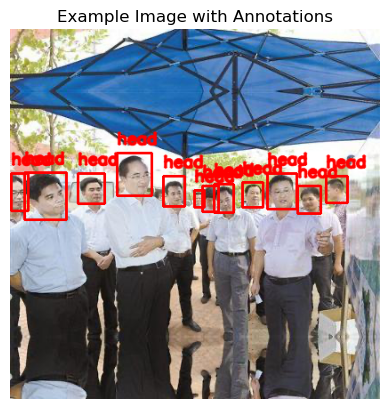

In [8]:
xml_path = 'Dataset/annotations/hard_hat_workers69.xml'
img_path = 'Dataset/images/hard_hat_workers69.png'

# Parse XML
filename, width, height, objects = parse_voc_annotation(xml_path)

# Load and draw image
img = cv2.imread(img_path)
img = draw_boxes(img, objects)

# Display the image
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.title("Example Image with Annotations")
plt.axis("off")
plt.show()

In [9]:
def extract_features_from_roi(img, objects, size=(64, 64)):
    features = []
    labels = []
    for obj in objects:
        label = obj["label"]
        xmin, ymin, xmax, ymax = obj["bbox"]
        roi = img[ymin:ymax, xmin:xmax]
        roi_resized = cv2.resize(roi, size)

        # Color histogram as feature vector
        hist = cv2.calcHist([roi_resized], [0, 1, 2], None,
                            [8, 8, 8], [0, 256, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()

        features.append(hist)
        labels.append(label)

    return features, labels

In [10]:
# from skimage.feature import hog

# def extract_features_from_roi(img, objects, size=(64, 64), pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
#     features = []
#     labels = []

#     for obj in objects:
#         label = obj["label"]
#         xmin, ymin, xmax, ymax = obj["bbox"]
#         roi = img[ymin:ymax, xmin:xmax]
#         roi_resized = cv2.resize(roi, size)

#         # Convert to grayscale for HOG
#         gray_roi = cv2.cvtColor(roi_resized, cv2.COLOR_BGR2GRAY)

#         # Compute HOG features
#         hog_features = hog(
#             gray_roi,
#             orientations=orientations,
#             pixels_per_cell=pixels_per_cell,
#             cells_per_block=cells_per_block,
#             block_norm='L2-Hys',
#             transform_sqrt=True,
#             feature_vector=True
#         )

#         features.append(hog_features)
#         labels.append(label)

#     return features, labels

In [ ]:
import glob

image_dir = 'Dataset/images/'
annotation_dir = 'Dataset/annotations/'

image_paths = sorted(glob.glob(image_dir + '*.png'))
annotation_paths = sorted(glob.glob(annotation_dir + '*.xml'))

X = []
y = []

for img_path, xml_path in zip(image_paths, annotation_paths):
    img = cv2.imread(img_path)
    processed = full_preprocessing_pipeline(img)  # Apply preprocessing
    preprocessed_img = processed["blured"]    # Choose a suitable version

    _, _, _, objects = parse_voc_annotation(xml_path)
    features, labels = extract_features_from_roi(preprocessed_img, objects)
  # features, labels = extract_features_from_roi(preprocessed_img, objects, size=(64, 64), pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9)

    X.extend(features)
    y.extend(labels)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Save the model to a file
joblib.dump(clf, 'random_forest_model.joblib')

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Train a classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Predict and evaluate
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=1))

# Save the model
joblib.dump(knn, 'knn_model.joblib')

# Confusion matrix
cm3 = confusion_matrix(y_test, y_pred, labels=knn.classes_)
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=knn.classes_)
disp3.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [15]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import joblib

class ObjectDetectionGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("Object Detection GUI")

        self.image_panel = tk.Label(root)
        self.image_panel.pack()

        self.btn_load = tk.Button(root, text="Load Image", command=self.load_image)
        self.btn_load.pack(side="left", padx=10, pady=10)

        self.btn_detect = tk.Button(root, text="Detect Objects", command=self.detect_objects)
        self.btn_detect.pack(side="right", padx=10, pady=10)

        self.current_image_path = None
        self.cv_img = None

    def load_image(self):
        path = filedialog.askopenfilename(filetypes=[("PNG files", "*.png")])
        if path:
            self.current_image_path = path
            self.cv_img = cv2.imread(path)
            img_rgb = cv2.cvtColor(self.cv_img, cv2.COLOR_BGR2RGB)
            img_pil = Image.fromarray(img_rgb)
            img_tk = ImageTk.PhotoImage(image=img_pil)

            self.image_panel.configure(image=img_tk)
            self.image_panel.image = img_tk  # Keep a reference!

    def detect_objects(self):
        if self.cv_img is None:
            return

        # Construct path to the corresponding annotation
        filename = self.current_image_path.split("/")[-1]
        xml_path = f"Dataset/annotations/{filename.replace('.png', '.xml')}"
        if not os.path.exists(xml_path):
            print("No corresponding annotation found.")
            return

        _, _, _, objects = parse_voc_annotation(xml_path)
        features, _ = extract_features_from_roi(self.cv_img, objects)
        predictions = model.predict(features)

        # Inject predictions as labels
        for i in range(len(objects)):
            objects[i]["label"] = predictions[i]

        # Draw boxes with predicted labels
        img_with_boxes = draw_boxes(self.cv_img.copy(), objects)
        img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img_rgb)
        img_tk = ImageTk.PhotoImage(image=img_pil)

        self.image_panel.configure(image=img_tk)
        self.image_panel.image = img_tk

if __name__ == "__main__":

    model = joblib.load("random_forest_model.joblib")  # or knn_model.joblib

    root = tk.Tk()
    app = ObjectDetectionGUI(root)
    root.mainloop()